---
title: "3D Forward Simulation of FDEM Data on Cylindrical Mesh for a Galvanic Source"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

Here we use the module *simpeg.electromagnetics.frequency_domain* to simulate the
FDEM response for a borehole survey using a cylindrical mesh and radially symmetric
conductivity model. For this tutorial, we focus on the following:

    - How to define the transmitters and receivers
    - How to define the survey
    - How to solve the FDEM problem on cylindrical meshes
    - The units of the conductivity/resistivity model and resulting data


Please note that we have used a coarse mesh to shorten the time of the simulation.
Proper discretization is required to simulate the fields at each frequency with
sufficient accuracy.


## Import modules




In [1]:
from discretize import CylindricalMesh
from discretize.utils import mkvc

from simpeg import maps
import simpeg.electromagnetics.frequency_domain as fdem
from simpeg.utils.solver_utils import get_default_solver

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

write_file = False

# sphinx_gallery_thumbnail_number = 2

## Create Borehole Survey

Here we define a x-offset borehole survey that consists of a single vertical line
of source-receiver pairs which measred the secondary magnetic flux density
over a range of frequencies.

In [3]:
# Frequencies being predicted (10 Hz to 10000 Hz)
frequencies = np.logspace(1, 4, 16)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid([0], [0], np.linspace(0, -500, 21))
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid([100], [0], np.linspace(0, -500, 21))
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(ntx):
    # Define receivers of different types at each location. Real and imaginary
    # measurements require separate receivers. You can define the orientation of
    # the transmitters and receivers for different survey geometries.
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )
    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]  # must be a list

    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list, frequencies[jj], source_locations[ii], orientation="z"
            )
        )

# Define the survey
survey = fdem.Survey(source_list)

## Create Cylindrical Mesh

Here we create the cylindrical mesh that will be used for this tutorial
example. We chose to design a coarser mesh to decrease the run time.
When designing a mesh to solve practical frequency domain problems:

    - Your smallest cell size should be 10%-20% the size of your smallest skin depth
    - The thickness of your padding needs to be 2-3 times biggest than your largest skin depth
    - The skin depth is ~500*np.sqrt(rho/f)





In [4]:
hr = [(10.0, 30), (10.0, 10, 1.5)]  # discretization in the radial direction
hz = [
    (10.0, 10, -1.5),
    (10.0, 200),
    (10.0, 10, 1.5),
]  # discretization in vertical direction

mesh = CylindricalMesh([hr, 1, hz], x0="00C")

## Create Conductivity/Resistivity Model and Mapping

Here, we create the model that will be used to predict frequency domain
data and the mapping from the model to the mesh. The model
consists of several layers. For this example, we will have only flat topography.




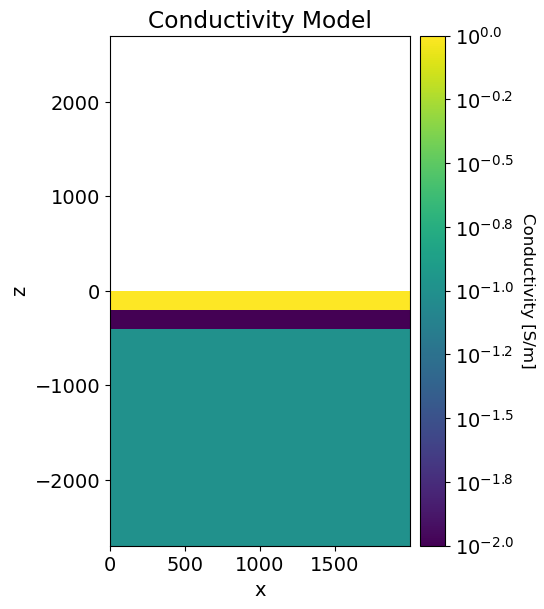

In [5]:
# Conductivity in S/m (or resistivity in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-1
layer_conductivity_1 = 1e0
layer_conductivity_2 = 1e-2

# Find cells that are active in the forward modeling (cells below surface)
ind_active = mesh.cell_centers[:, 2] < 0

# Define mapping from model to active cells
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define the model
model = background_conductivity * np.ones(ind_active.sum())
ind = (mesh.cell_centers[ind_active, 2] > -200.0) & (
    mesh.cell_centers[ind_active, 2] < -0
)
model[ind] = layer_conductivity_1
ind = (mesh.cell_centers[ind_active, 2] > -400.0) & (
    mesh.cell_centers[ind_active, 2] < -200
)
model[ind] = layer_conductivity_2

# Plot Conductivity Model
mpl.rcParams.update({"font.size": 14})
fig = plt.figure(figsize=(5, 6))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
log_model = np.log10(model)

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh.plot_image(
    plotting_map * log_model,
    ax=ax1,
    grid=False,
    clim=(np.log10(layer_conductivity_2), np.log10(layer_conductivity_1)),
)
ax1.set_title("Conductivity Model")

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.log10(layer_conductivity_2), vmax=np.log10(layer_conductivity_1)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

## Simulation: Predicting FDEM Data

Here we define the formulation for solving Maxwell's equations. Since we are
measuring the magnetic flux density and working with a conductivity model,
the EB formulation is the most natural. We must also remember to define
the mapping for the conductivity model. If you defined a resistivity model,
use the kwarg *rhoMap* instead of *sigmaMap*




In [6]:
simulation = fdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=model_map, solver=get_defaut_solver()
)

## Predict and Plot Data

Here we show how the simulation is used to predict data.




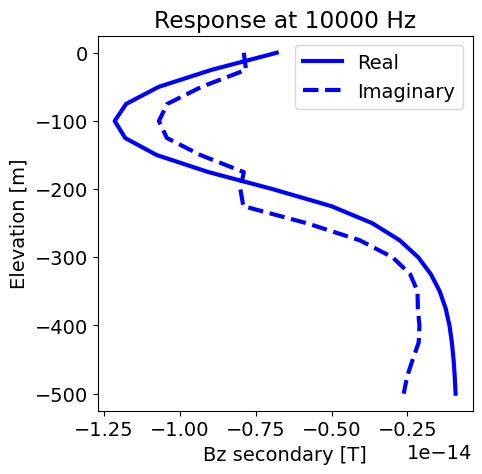

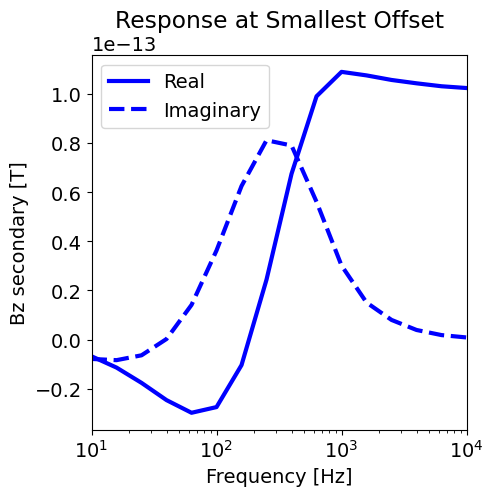

In [7]:
# Compute predicted data for the given model.
dpred = simulation.dpred(model)

# Data are organized by transmitter location, then component, then frequency. We had nFreq
# transmitters and each transmitter had 2 receivers (real and imaginary component). So
# first we will pick out the real and imaginary data
bz_real = dpred[0 : len(dpred) : 2]
bz_imag = dpred[1 : len(dpred) : 2]

# Then we will will reshape the data.
bz_real = np.reshape(bz_real, (ntx, len(frequencies)))
bz_imag = np.reshape(bz_imag, (ntx, len(frequencies)))

# Plot secondary field along the profile at f = 10000 Hz
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.2, 0.15, 0.75, 0.75])
frequencies_index = 0
ax1.plot(bz_real[:, frequencies_index], receiver_locations[:, -1], "b-", lw=3)
ax1.plot(bz_imag[:, frequencies_index], receiver_locations[:, -1], "b--", lw=3)
ax1.set_xlabel("Bz secondary [T]")
ax1.set_ylabel("Elevation [m]")
ax1.set_title("Response at 10000 Hz")
ax1.legend(["Real", "Imaginary"], loc="upper right")

# Plot FEM response for all frequencies
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.2, 0.15, 0.75, 0.75])
location_index = 0
ax1.semilogx(frequencies, bz_real[location_index, :], "b-", lw=3)
ax1.semilogx(frequencies, bz_imag[location_index, :], "b--", lw=3)
ax1.set_xlim((np.min(frequencies), np.max(frequencies)))
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Bz secondary [T]")
ax1.set_title("Response at Smallest Offset")
ax1.legend(["Real", "Imaginary"], loc="upper left")